# Evolution du bruit médian en France depuis le début de la pandémie

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize
from scipy.signal import hilbert

try:
    os.environ["PROJ_LIB"] = r'/home/flavien/anaconda3/envs/SeismicNoise2A/share/basemap/'
except:
    pass
from mpl_toolkits.basemap import Basemap


from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"
year_ref = 2019

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)
list_stations = ["FR.STR.00.HHZ"]

In [3]:
events = {
    "Lockdown 1" :      "2020-03-17",
    "Lockdown 1 exit" : "2020-05-11",
    "Lockdown 2" :      "2020-10-30",
    "Lockdown 2 exit" : "2020-12-15",
    "Christmas" :       "2020-12-25",
    "New Year" :        "2021-01-01",
    "Curfew 18h-6h" :   "2021-01-16",
    "Lockdown 3" :      "2021-04-03"
}

In [4]:
tags = {
    "2020-03-17": "Lockdown 1",
    "2020-05-11": "End lockdown",
    "2020-10-30": "Lockdown 2",
    "2020-12-15": "End lockdown + Curfew 20h",
    "2020-12-25": "Christmas",
    "2021-01-01": "New Year",
    "2021-01-16": "Curfew 18h",
    "2021-03-20": "Curfew 19h",
    "2021-04-03": "Lockdown 3",
    "2021-05-03": "End of certificate",
    "2021-05-19": "Curfew 21h + Shops open",
    "2021-06-09": "Curfew 23h + Restaurants open",
    "2021-06-30": "End Curfew",
    "2021-05-03": "Déconfinement",
    "2021-05-03": "Déconfinement",
    "2021-05-03": "Déconfinement",
    "2021-05-03": "Déconfinement"
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

---
## Médiane à toutes les stations

#### Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [5]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

0it [00:00, ?it/s]

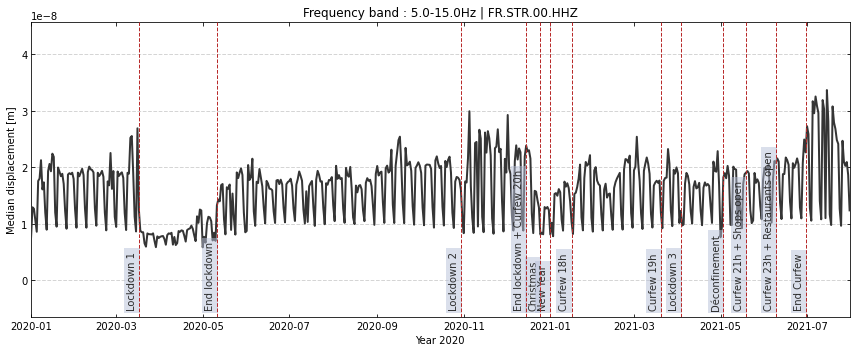

1it [00:00,  2.16it/s]


In [6]:
med_values = []
st_list = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index=pd.to_datetime(dataframe.index)
        dRMS = dataframe
    except:
        continue
        
    st_list = np.append(st_list, st_str)    
        
    ### On garde les données dans la période temporelle qui nous intéresse
    # dRMS de référence (2019)
    mask_ref = (dataframe.index > pd.Timestamp("2019-01-01")) & (dataframe.index <= pd.Timestamp("2020-01-01"))
    dRMS_ref = dRMS.loc[mask_ref]
    submask = (dRMS_ref.index > (tStart - pd.Timedelta("365 days"))) & (dRMS_ref.index <= (tEnd - pd.Timedelta("731 days")))
    dRMS_sub = dRMS_ref.loc[submask]
    dRMS_sub.index = dRMS_sub.index + pd.offsets.DateOffset(years=1)
    dRMS_2019 = pd.concat([dRMS_ref, dRMS_sub])
    
    # dRMS à comparer (2020-2021)
    mask_time = (dataframe.index > tStart) & (dataframe.index <= tEnd)
    dRMS = dRMS.loc[mask_time]
    
    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "16:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')
    

    ### Mise en graphique
    color = "#353535"
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.tick_params(direction="in", which="both", top=True, right=True)
    ax.set_title("Frequency band : {}Hz | {}".format(freq, st_str))
    ax.plot(dRMS_med, color=color, lw=2, zorder=3)
    plt.ylim(-1*np.nanquantile(dRMS_med, 0.01), 1.5*np.nanquantile(dRMS_med, 0.99))
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_xlabel("Year 2020")
    ax.set_ylabel("Median displacement [m]")

    box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("5 days")
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
        ax.text(t_text, -0.8*np.nanquantile(dRMS_med, 0.01), desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1

    plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
    plt.tight_layout()
    # plt.savefig("RESULTS/FR_2020/noise_stations/{}_{}.png".format(st_str, freq), dpi=300)
    plt.show()
    # plt.close()
    # plt.clf()

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    # norm = np.nanmedian(dRMS_med)
    # dRMS_med = dRMS_med/norm
    med_values.append(dRMS_med)

In [7]:
dRMS_2019

,0.0-0.0,0.1-0.2,0.3-1.0,1.0-3.0,5.0-15.0,20.0-50.0
2019-01-01 00:30:00,2.689699e-06,2.783007e-07,5.640627e-08,1.187134e-08,6.769773e-09,1.120006e-09
2019-01-01 01:00:00,2.741530e-06,2.704699e-07,5.736759e-08,1.159693e-08,7.133149e-09,1.260698e-09
2019-01-01 01:30:00,2.628692e-06,2.785670e-07,5.608565e-08,1.114154e-08,7.139587e-09,1.301513e-09
2019-01-01 02:00:00,2.466790e-06,2.780552e-07,5.582185e-08,1.049335e-08,6.936594e-09,1.184261e-09
2019-01-01 02:30:00,2.424481e-06,2.894002e-07,5.500531e-08,9.727345e-09,6.431401e-09,1.149614e-09
...,...,...,...,...,...,...
2020-07-31 21:00:00,1.589374e-06,8.727123e-08,6.095598e-08,1.213351e-08,9.203680e-09,1.100131e-09
2020-07-31 21:30:00,1.350135e-06,8.477855e-08,5.808528e-08,1.059734e-08,8.305999e-09,1.059712e-09
2020-07-31 22:00:00,1.410461e-06,8.760225e-08,5.854328e-08,1.040087e-08,7.718771e-09,9.867707e-10
2020-07-31 22:30:00,1.060419e-06,8.702870e-08,5.974661e-08,9.506235e-09,5.740645e-09,8.977412e-10


In [8]:
# dates_diff = list()
# noise_diff = list()

# for index, row in dRMS.iterrows():
        
#     day = index
#     if index.year == 2021: day2019 = index - pd.offsets.DateOffset(years=2)
#     if index.year == 2020: day2019 = index - pd.offsets.DateOffset(years=1)

#     dvalue = row[freq]
#     dref = dRMS_ref.loc[dRMS_ref.index == day2019][freq]
    
#     if len(dref) != 0:
#         diff = (dvalue-dref)/dref * 100

#         dates_diff = np.append(dates_diff, day)
#         noise_diff = np.append(noise_diff, diff)

In [30]:
noise_2019  = np.asarray(dRMS_2019[freq].resample("1D").median()[1:].tolist())
noise_covid = np.asarray(dRMS[freq].resample("1D").median().tolist())
dates_diff  = dRMS.resample("1D").median().index
data_diff   = (noise_covid-noise_2019)/noise_2019 * 100

In [31]:
# data_diff = pd.DataFrame(noise_diff, index=dates_diff)

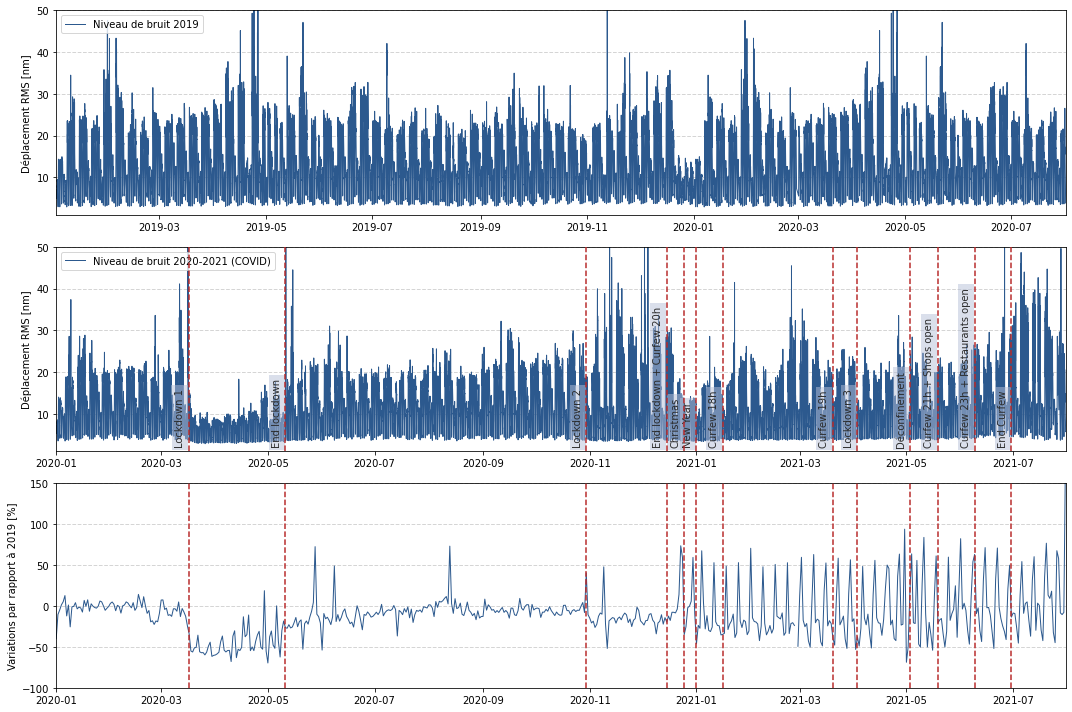

In [32]:
box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

plt.figure(figsize=(15, 10))

plt.subplot(313)
plt.plot(dates_diff, data_diff, color="#2C598E", lw=1)
plt.ylim(-100, 150)
plt.xlim(dates_diff[0], dates_diff[-1])
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylabel("Variations par rapport à 2019 [%]")

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1


plt.subplot(312)
plt.plot(dRMS[freq]*1e9, color="#2C598E", lw=1)
plt.ylim(1e-9/1e-9, 0.5e-7/1e-9)
plt.xlim(dates_diff[0], dates_diff[-1])
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.legend(["Niveau de bruit 2020-2021 (COVID)"], loc=2)
plt.ylabel("Déplacement RMS [nm]")

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    plt.axvline(t_search, ls="--", lw=1.5, color="#B82A2A", zorder=10)   # Confinement 1
    plt.text(t_text, 2, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
    
plt.subplot(311)
plt.plot(dRMS_2019[freq]*1e9, color="#2C598E", lw=1)
plt.ylim(1e-9/1e-9, 0.5e-7/1e-9)
plt.xlim(dRMS_2019.index[0], dRMS_2019.index[-1])
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.legend(["Niveau de bruit 2019"], loc=2)
plt.ylabel("Déplacement RMS [nm]")  

plt.tight_layout()

plt.savefig("results/var_STR_2019_COVID.png", dpi=300)

In [ ]:
### Mise en graphique
color = "#353535"
fig, ax = plt.subplots(figsize=(12, 5))
plt.subplot(211)
ax.tick_params(direction="in", which="both", top=True, right=True)
ax.set_title("Frequency band : {}Hz | {}".format(freq, st_str))
ax.plot(dRMS_med, color=color, lw=2, zorder=3)
plt.ylim(-1*np.nanquantile(dRMS_med, 0.01), 1.5*np.nanquantile(dRMS_med, 0.99))
ax.set_xlim([dates[0], dates[-1]])
ax.set_xlabel("Year 2020")
ax.set_ylabel("Median displacement [m]")https://www.youtube.com/watch?v=gf2dbPFhb0g

box_txt = dict(boxstyle="square",
           facecolor='#B7C0D8',
           edgecolor='none',
           alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -0.8*np.nanquantile(dRMS_med, 0.01), desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.tight_layout()
# plt.savefig("RESULTS/FR_2020/noise_stations/{}_{}.png".format(st_str, freq), dpi=300)
plt.show()

In [70]:
day2019

Timestamp('2019-07-31 23:00:00')

In [76]:
dRMS_ref.loc[dRMS_ref.index == day2019][freq]

Series([], Name: 5.0-15.0, dtype: float64)

In [65]:
dRMS_ref

,0.0-0.0,0.1-0.2,0.3-1.0,1.0-3.0,5.0-15.0,20.0-50.0
2019-01-01 00:30:00,2.689699e-06,2.783007e-07,5.640627e-08,1.187134e-08,6.769773e-09,1.120006e-09
2019-01-01 01:00:00,2.741530e-06,2.704699e-07,5.736759e-08,1.159693e-08,7.133149e-09,1.260698e-09
2019-01-01 01:30:00,2.628692e-06,2.785670e-07,5.608565e-08,1.114154e-08,7.139587e-09,1.301513e-09
2019-01-01 02:00:00,2.466790e-06,2.780552e-07,5.582185e-08,1.049335e-08,6.936594e-09,1.184261e-09
2019-01-01 02:30:00,2.424481e-06,2.894002e-07,5.500531e-08,9.727345e-09,6.431401e-09,1.149614e-09
...,...,...,...,...,...,...
2020-07-31 21:00:00,1.589374e-06,8.727123e-08,6.095598e-08,1.213351e-08,9.203680e-09,1.100131e-09
2020-07-31 21:30:00,1.350135e-06,8.477855e-08,5.808528e-08,1.059734e-08,8.305999e-09,1.059712e-09
2020-07-31 22:00:00,1.410461e-06,8.760225e-08,5.854328e-08,1.040087e-08,7.718771e-09,9.867707e-10
2020-07-31 22:30:00,1.060419e-06,8.702870e-08,5.974661e-08,9.506235e-09,5.740645e-09,8.977412e-10


In [71]:
dRMS_ref.index == day2019

array([False, False, False, ..., False, False, False], dtype=bool)

(1e-09, 6e-08)

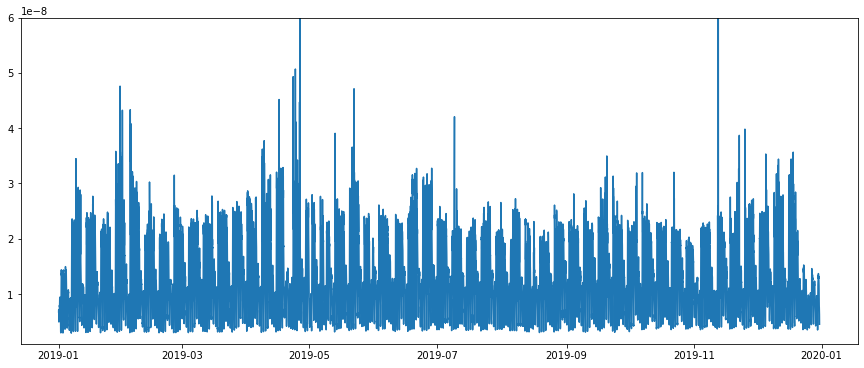

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(dRMS_ref[freq])
plt.ylim(1e-9, 0.6e-7)

In [24]:
print(tStart - pd.Timedelta("365 days"))
print(tEnd - pd.Timedelta("731 days"))

2019-01-01 00:00:00
2019-08-01 00:00:00


In [7]:
print("Dimensions de la matrice :", np.shape(med_values))

Dimensions de la matrice : (142, 578)


In [8]:
# dRMS_array = med_values

# np.save('sandbaox/dates', dates)
# np.save('sandbox/st_list', st_list)
# np.save('sandbox/dRMS_array', dRMS_array)

#### Calcul de la médiane de toutes les stations

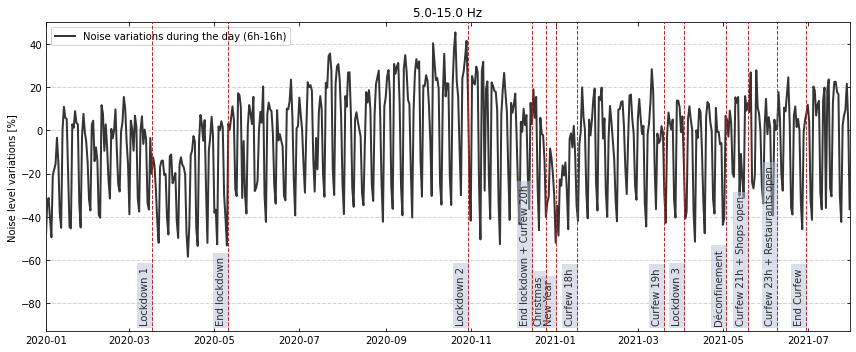

In [9]:
noise_fr = np.zeros(nDays)


for i in range(nDays):

    sublist = list()

    for j in range(np.shape(med_values)[0]):
        sublist = np.append(sublist, med_values[j][i])

    noise_fr[i] = np.nanmedian(sublist)


norm_period = ["2020-01-15", "2020-03-10"]
t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
noise_med = np.nanmedian(noise_fr)
noise_fr = (noise_fr - noise_med)/noise_med*100

color = "#353535"
fig, ax = plt.subplots(figsize=(12, 5))
ax.tick_params(direction="in", which="both", top=True, right=True)
# ax.set_title("Frequency band : {}Hz".format(freq))
ax.plot(dates, noise_fr, color=color, lw=2, zorder=3, label="Noise variations during the day (6h-16h)")
plt.ylim(3.5 * np.quantile(noise_fr, 0.05), 5 * np.quantile(noise_fr, 0.95))
ax.set_xlim([dates[0], dates[-1]])
# ax.set_xlabel("Year 2020")
ax.set_ylabel("Noise level variations [%]")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -90, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

med_var = np.zeros(np.shape(med_values))

for i in range(np.shape(med_var)[0]):
    sub_list = med_values[i][:]    
    med_var[i][:] = (sub_list - np.nanmedian(sub_list))/np.nanmedian(sub_list) * 100
    
    
std = np.nanstd(med_var, axis=0)
    
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-93, 50)
plt.legend(loc=2)
plt.title("{} Hz".format(freq))
plt.tight_layout()
folder = "RESULTS/FR_2020/hour_{}Hz/".format(freq)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("RESULTS/FR_2020/hour_{}Hz/noise_DAY.png".format(freq), dpi=300)
plt.show()

In [10]:
def enveloppe(x, f):
    lmin = (np.diff(np.sign(np.diff(f))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(f))) < 0).nonzero()[0] + 1 

    idx_down = lmin[[i+np.argmin(f[lmin[i:i+1]]) for i in range(0,len(lmin), 1)]]
    idx_up = lmax[[i+np.argmax(f[lmax[i:i+1]]) for i in range(0,len(lmax), 1)]]
    
    env_down = np.interp(x, x[idx_down], f[idx_down])
    env_up = np.interp(x, x[idx_up], f[idx_up])
    
    return env_down, env_up

In [11]:
env_up_matrix = np.zeros(np.shape(med_var))
env_down_matrix = np.zeros(np.shape(med_var))

for i in range(np.shape(med_var)[0]):
    sub_list = med_var[i][:]
    env_down, env_up = enveloppe(dates, sub_list)
    env_up_matrix[i][:] = env_up
    env_down_matrix[i][:] = env_down

<ipython-input-12-74bc4aae7458>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dates, st_list, med_var)


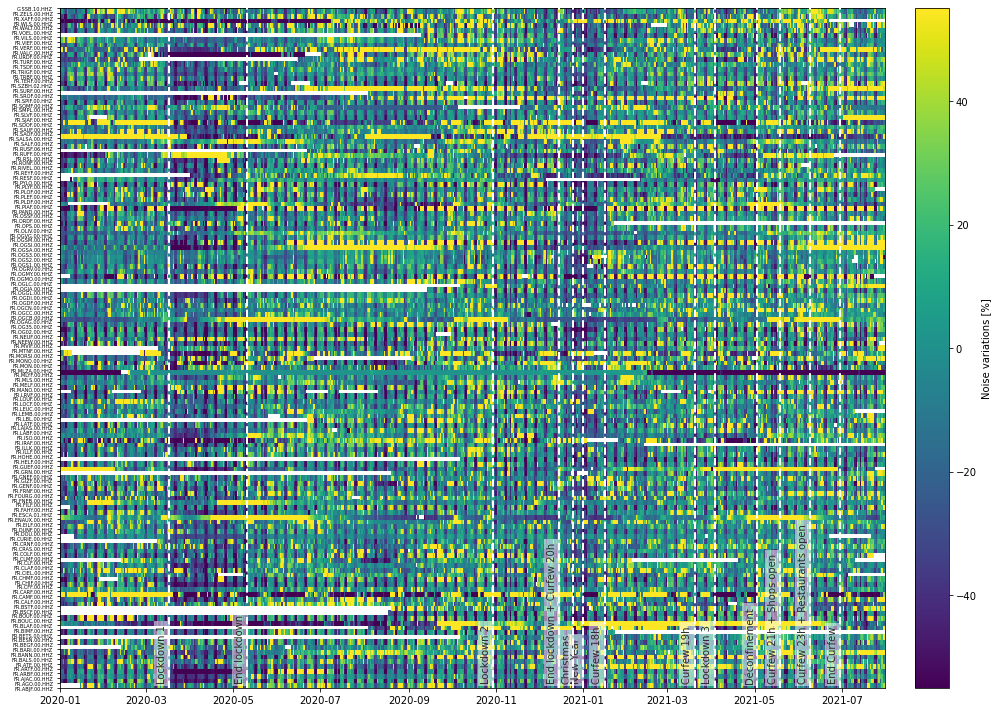

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.pcolormesh(dates, st_list, med_var)
plt.tick_params(axis='y', labelsize=5)

box_txt = dict(boxstyle="square",
               facecolor='white',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1
    plt.text(t_text, 1, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
plt.clim(-55, 55)
plt.colorbar(orientation="vertical", label='Noise variations [%]', pad=0.03)
plt.tight_layout()
plt.savefig('RESULTS/FR_2020/all_stations_{}Hz.png'.format(freq), dpi=150)

---
## Médiane à toutes les stations par heure

In [13]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [14]:
h_list = [ "0:30", "1:30", "2:30", "3:30", "4:30", "5:30", "6:30", "7:30", "8:30", "9:30", "10:30",
           "11:30", "12:30", "13:30", "14:30", "15:30", "16:30", "17:30", "18:30", "19:30", "20:30",
           "21:30", "22:30", "23:30"]
h_mid = np.arange(0, 24, 1)
h_matrix = np.zeros((24, np.shape(med_var)[1]))

for k in tqdm.tqdm(range(len(h_list))):

    med_values = []

    for j, st_str in enumerate(list_stations):
        # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

        ### Calcul du déplacement RMS de la station
        try:
            dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
            dataframe.index = pd.to_datetime(dataframe.index)
            dRMS = dataframe
        except:
            continue

        ### On garde les données dans la période temporelle qui nous intéresse
        mask_time = (dataframe.index > tStart) & (dataframe.index <= tEnd)
        dRMS = dRMS.loc[mask_time]

        ### Récupération du bruit
        dRMS_med = dRMS[freq].between_time(h_list[k-1], h_list[k]).resample("1D").median()
        dRMS_med = dfDates.join(dRMS_med, how='outer')

        ### Normalisation du bruit
        dRMS_med = dRMS_med[freq].tolist()
        norm = np.nanmedian(dRMS_med)
        dRMS_med = dRMS_med/norm
        if len(dRMS_med) > len(dates):
            dRMS_med = dRMS_med[:len(dates)]
            
        # print(len(dRMS_med))
        
        med_values.append(dRMS_med)

    noise_fr = np.zeros(nDays)

    for i in range(nDays):

        sublist = list()

        for j in range(np.shape(med_values)[0]):
            sublist.append(med_values[j][i])

        noise_fr[i] = np.nanmedian(sublist)

    norm_period = ["2020-01-15", "2020-03-10"]
    t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
    t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
    noise_med = np.nanmedian(noise_fr)
    noise_fr = (noise_fr - noise_med)/noise_med*100

    color = "#353535"
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.tick_params(direction="in", which="both", top=True, right=True)
    ax.plot(dates, noise_fr, color=color, lw=2, zorder=3, label="Noise variations at {}h ({}-{})".format(h_mid[k], h_list[k-1], h_list[k]))
    plt.ylim(-75, 75)
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_ylabel("Noise level variations [%]")

    box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("5 days")
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
        ax.text(t_text, -70, desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1

    h_matrix[k][:] = noise_fr
        
    plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
    plt.legend(loc=2)
    plt.title("{} Hz".format(freq))
    plt.tight_layout()
    folder = "RESULTS/FR_2020/hour_{}Hz/".format(freq)
    plt.savefig("RESULTS/FR_2020/hour_{}Hz/noise_{}h.png".format(freq, h_mid[k]), dpi=300)
    plt.clf()
    plt.close()

100%|██████████| 24/24 [02:52<00:00,  7.18s/it]


<ipython-input-34-8dbd1cf9029e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dates, h_mid, h_matrix)


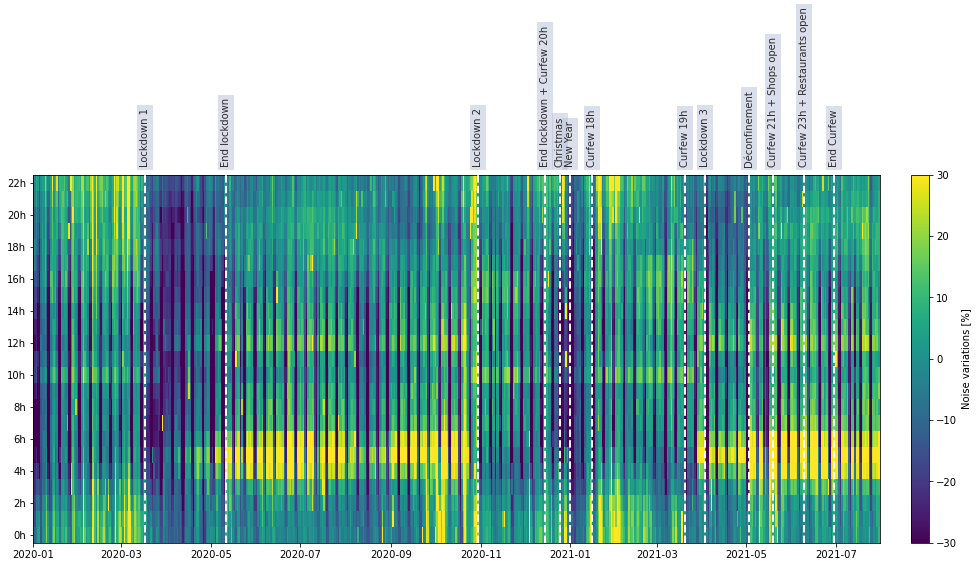

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.pcolormesh(dates, h_mid, h_matrix)

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("0 days")
    plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1
    plt.text(t_text, 23.5, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
h_label = ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"]
plt.yticks(np.arange(0.5, 24, 2), h_label)
plt.clim(-30, 30)
plt.colorbar(orientation="vertical", label='Noise variations [%]', pad=0.03)
plt.tight_layout()
plt.savefig('RESULTS/FR_2020/hour_{}Hz/noise_all_hours.png'.format(freq), dpi=150)